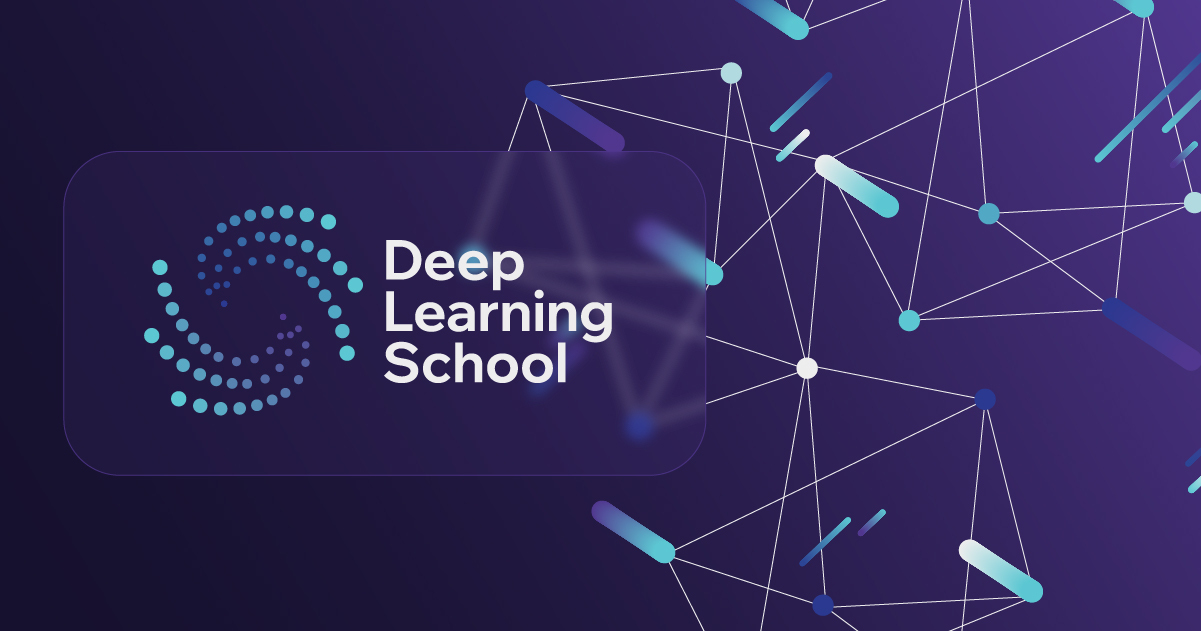


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>


# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [11]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [14]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Apr 16 09:34:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [13]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [15]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/simpsons/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/simpsons/testset')

In [16]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [17]:
!python --version

Python 3.11.11


In [18]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
tqdm version: 4.67.1
matplotlib version: 3.7.5
seaborn version: 0.12.2
Pillow version: 11.1.0


#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


In [19]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

In [20]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [21]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [22]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [23]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [24]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

Давайте посмотрим на наших героев внутри датасета.

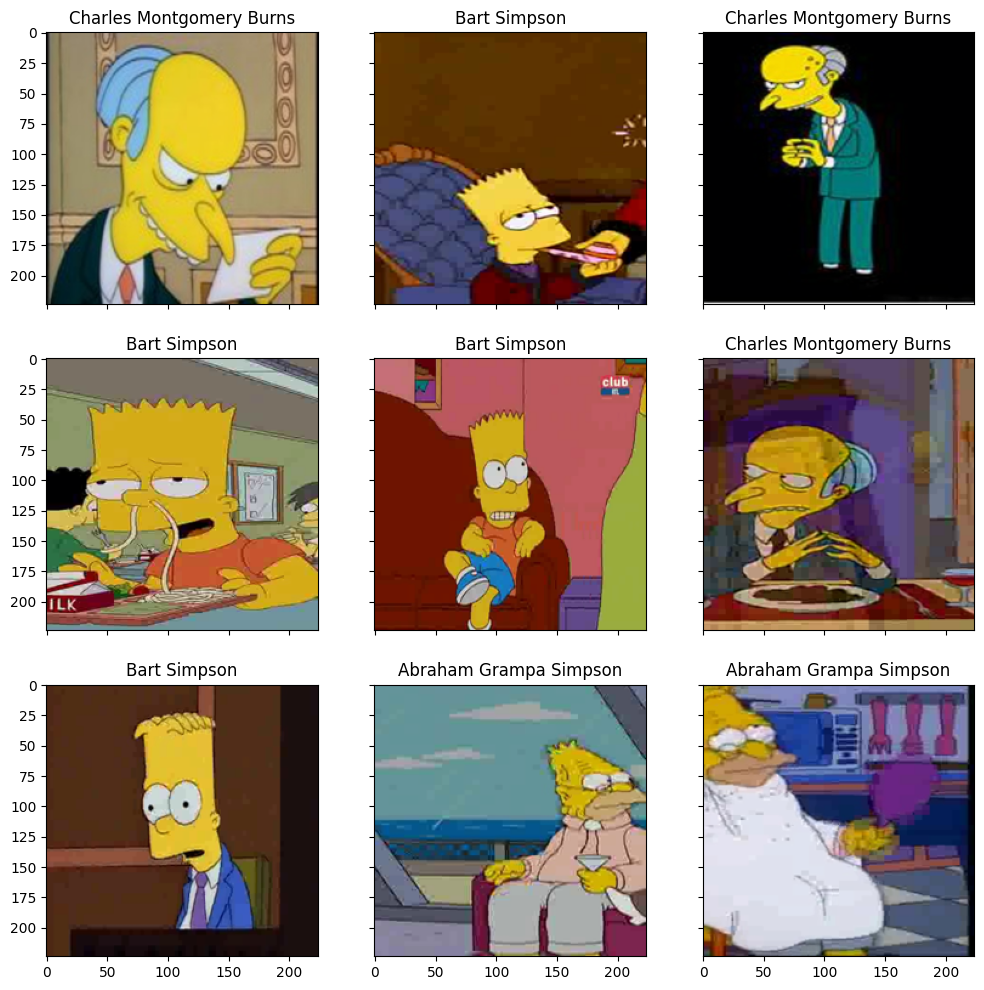

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [26]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

#### Функция обучения:

In [27]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [28]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [29]:
def train(train_files, val_files, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [30]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [32]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
# Выводим значения валидационных метрик
print("Validation Loss:")
for epoch, v_loss in enumerate(val_loss, 1):
    print(f"Epoch {epoch}: {v_loss:.4f}")

print("\nValidation Accuracy:")
for epoch, v_acc in enumerate(val_acc, 1):
    print(f"Epoch {epoch}: {v_acc:.4f}")

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

In [ ]:
import pandas as pd

# Создаем DataFrame с именами файлов и предсказанными классами
submission = pd.DataFrame({
    'Image_id': test_filenames,  # Имена файлов из test_dataset
    'Expected': preds            # Предсказанные классы
})

# Пример содержимого:
print(submission.head())

In [ ]:
#import pandas as pd
#my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
#my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:
1. Работа с датасетом:
* проверка (EDA) и предобработка;
* дополнение, выравниванике кол-ва картинок в классах - изменять можно как сами картинки, формируя новый датасет, или в класссе SimpsonsDataset;
* с помощью [аугментации](https://habr.com/ru/companies/smartengines/articles/264677/) или [без](https://www.geeksforgeeks.org/python-data-augmentation/);

2. Рабта с архитектурой сети:
* учим дольше и изменяем (подбираем) гиперпараметры: learning rate, batch size, нормализация картинки и вот это всё;
* добавление/удаление свёрточных слоёв;
* кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять!

3. Улучшение оптимизации:
* ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

4. Файнтютинг и трансферлёнинг:
* ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

5. Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


План работы:
Сравнить варианты обучения:
- BaseLine нейросеть
- С добавлением batch_norm и augmentation
- С одним, двумя skip connection
- С дообучением на базе ResNet
Дальнейшие действия определим в процессе выполнения

# **Добавление BatchNorm и Аugmentation**

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
history1 = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

In [ ]:
loss1, acc1, val_loss1, val_acc1 = zip(*history1)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
# Выводим значения валидационных метрик
print("Validation Loss:")
for epoch, v_loss in enumerate(val_loss1, 1):
    print(f"Epoch {epoch}: {v_loss:.4f}")

print("\nValidation Accuracy:")
for epoch, v_acc in enumerate(val_acc1, 1):
    print(f"Epoch {epoch}: {v_acc:.4f}")

**Модель Bazeline:** train_acc 0.7142, val_acc 0.7027

**Модель с BatchNorm и Augmentation:** train_acc 0.8551, val_acc 0.7530


# **Добавление один Skip Connections**(на третьем слое)


In [ ]:
class SimpleCnnWithOneSkip(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # На выходе 5-го слоя 96 каналов, следовательно skip_conv должен иметь столько же
        # stride 4, так как MaxPooling дает двукратное уменьшение в два раза
        self.skip_conv = nn.Conv2d(32, 96, kernel_size=1, stride=4)  # Для согласования размеров
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x3 = self.conv3(x) 
        
        x = self.conv4(x3)
        x = self.conv5(x)
        
        skip = self.skip_conv(x3)
        x = x + skip  
        
        x = x.view(x.size(0), -1)
        return self.out(x)

In [ ]:
history2 = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

In [ ]:
loss2, acc2, val_loss2, val_acc2 = zip(*history2)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
# Выводим значения валидационных метрик
print("Validation Loss:")
for epoch, v_loss in enumerate(val_loss1, 1):
    print(f"Epoch {epoch}: {v_loss:.4f}")

print("\nValidation Accuracy:")
for epoch, v_acc in enumerate(val_acc1, 1):
    print(f"Epoch {epoch}: {v_acc:.4f}")

На удивление val_accuracy вырос всего на 0.01
Попробуем вариант с двумя skip conection

# **Добавление двух Skip Connection**

In [ ]:
class SimpleCnnWithOneSkip(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.skip_conv1 = nn.Conv2d(16, 64, kernel_size=1, stride=4)   # Для первого skip
        self.skip_conv2 = nn.Conv2d(32, 96, kernel_size=1, stride=4)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x2 = self.conv2(x)  
        x3 = self.conv3(x2)  
        
        x = self.conv4(x3)
        skip1 = self.skip_conv1(x2)
        x = x + skip1
        
        x = self.conv5(x)
        skip2 = self.skip_conv2(x3)
        x = x + skip2
        
        x = x.view(x.size(0), -1)
        return self.out(x)

In [ ]:
history3 = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

In [ ]:
loss3, acc3, val_loss3, val_acc3 = zip(*history2)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
# Выводим значения валидационных метрик
print("Validation Loss:")
for epoch, v_loss in enumerate(val_loss1, 1):
    print(f"Epoch {epoch}: {v_loss:.4f}")

print("\nValidation Accuracy:")
for epoch, v_acc in enumerate(val_acc1, 1):
    print(f"Epoch {epoch}: {v_acc:.4f}")

Видим, что добавление второго Skip Conection улучшило точность только на 0.02
Следовательно, надо переходить к тяжелой артилерии

# **Дообучением на базе ResNet (обучаем линейный слой и последний слой свертки)**

In [49]:
import numpy as np
from collections import Counter
import random
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pickle
import torchvision.transforms as transforms
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

In [50]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = Image.fromarray(x)
        
        if self.mode == 'train':
            augmentation = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            x = augmentation(x)
        
        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [51]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [53]:
def train(train_files, val_files, model, epochs, batch_size, optimiser, criterion):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimiser
        criterion = criterion

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [54]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
in_features = model.fc.in_features 
model.fc = nn.Linear(in_features, n_classes)

for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

resnet50 = model.to(DEVICE)

optimiser = torch.optim.Adam(resnet50.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

history = train(train_dataset, val_dataset, model=resnet50, epochs=10, batch_size=128, optimiser=optimiser, criterion=criterion)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth

  0%|          | 0.00/97.8M [00:00<?, ?B/s]
  9%|▊         | 8.38M/97.8M [00:00<00:01, 87.8MB/s]
 31%|███▏      | 30.8M/97.8M [00:00<00:00, 174MB/s] 
 52%|█████▏    | 50.9M/97.8M [00:00<00:00, 190MB/s]
 73%|███████▎  | 71.1M/97.8M [00:00<00:00, 199MB/s]
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.1324639719446357



epoch:  10%|█         | 1/10 [04:32<40:52, 272.49s/it]
                                                   
epoch:  10%|█         | 1/10 [04:32<40:52, 272.49s/it]


Epoch 001 train_loss: 1.1325     val_loss 0.4796 train_acc 0.7165 val_acc 0.8724
loss 0.7595491416211781



epoch:  20%|██        | 2/10 [08:02<31:24, 235.57s/it]
                                                   
epoch:  20%|██        | 2/10 [08:02<31:24, 235.57s/it]


Epoch 002 train_loss: 0.7595     val_loss 0.3616 train_acc 0.7999 val_acc 0.9056
loss 0.5488384534666604



epoch:  30%|███       | 3/10 [11:32<26:07, 223.89s/it]
                                                   
epoch:  30%|███       | 3/10 [11:32<26:07, 223.89s/it]


Epoch 003 train_loss: 0.5488     val_loss 0.3158 train_acc 0.8542 val_acc 0.9159
loss 0.49190677063154853



epoch:  40%|████      | 4/10 [15:00<21:46, 217.68s/it]
                                                   
epoch:  40%|████      | 4/10 [15:00<21:46, 217.68s/it]


Epoch 004 train_loss: 0.4919     val_loss 0.2629 train_acc 0.8676 val_acc 0.9326
loss 0.4555879774724035



epoch:  50%|█████     | 5/10 [18:29<17:52, 214.56s/it]
                                                   
epoch:  50%|█████     | 5/10 [18:29<17:52, 214.56s/it]


Epoch 005 train_loss: 0.4556     val_loss 0.2542 train_acc 0.8809 val_acc 0.9339
loss 0.40829511179773054



epoch:  60%|██████    | 6/10 [21:58<14:11, 212.83s/it]
                                                   
epoch:  60%|██████    | 6/10 [21:58<14:11, 212.83s/it]


Epoch 006 train_loss: 0.4083     val_loss 0.2374 train_acc 0.8902 val_acc 0.9356
loss 0.3944870341666239



epoch:  70%|███████   | 7/10 [25:26<10:33, 211.11s/it]
                                                   
epoch:  70%|███████   | 7/10 [25:26<10:33, 211.11s/it]


Epoch 007 train_loss: 0.3945     val_loss 0.1799 train_acc 0.8944 val_acc 0.9532
loss 0.35906964231239047



epoch:  80%|████████  | 8/10 [28:52<06:59, 209.64s/it]
                                                   
epoch:  80%|████████  | 8/10 [28:52<06:59, 209.64s/it]


Epoch 008 train_loss: 0.3591     val_loss 0.2031 train_acc 0.9024 val_acc 0.9503
loss 0.3807612291733409



epoch:  90%|█████████ | 9/10 [32:21<03:29, 209.41s/it]
                                                   
epoch:  90%|█████████ | 9/10 [32:21<03:29, 209.41s/it]


Epoch 009 train_loss: 0.3808     val_loss 0.2190 train_acc 0.8990 val_acc 0.9433
loss 0.3310110733113294



epoch: 100%|██████████| 10/10 [35:48<00:00, 208.46s/it]
                                                    
epoch: 100%|██████████| 10/10 [35:48<00:00, 214.82s/it]


Epoch 010 train_loss: 0.3310     val_loss 0.2268 train_acc 0.9117 val_acc 0.9421


In [55]:
# Найдём эпоху с минимальной val_loss
best_epoch_by_loss = min(enumerate(history), key=lambda x: x[1][2])
best_epoch_idx = best_epoch_by_loss[0]
best_val_loss = best_epoch_by_loss[1][2]
best_val_acc = best_epoch_by_loss[1][3]

print(f"🏆 Лучшая эпоха по val_loss: {best_epoch_idx + 1}")
print(f"   val_loss = {best_val_loss:.4f}, val_acc = {best_val_acc:.4f}")


🏆 Лучшая эпоха по val_loss: 7
   val_loss = 0.1799, val_acc = 0.9532


In [56]:
best_epoch_by_acc = max(enumerate(history), key=lambda x: x[1][3])
print(f"📈 Лучшая эпоха по val_acc: {best_epoch_by_acc[0] + 1}")
print(f"   val_acc = {best_epoch_by_acc[1][3]:.4f}, val_loss = {best_epoch_by_acc[1][2]:.4f}")

📈 Лучшая эпоха по val_acc: 7
   val_acc = 0.9532, val_loss = 0.1799


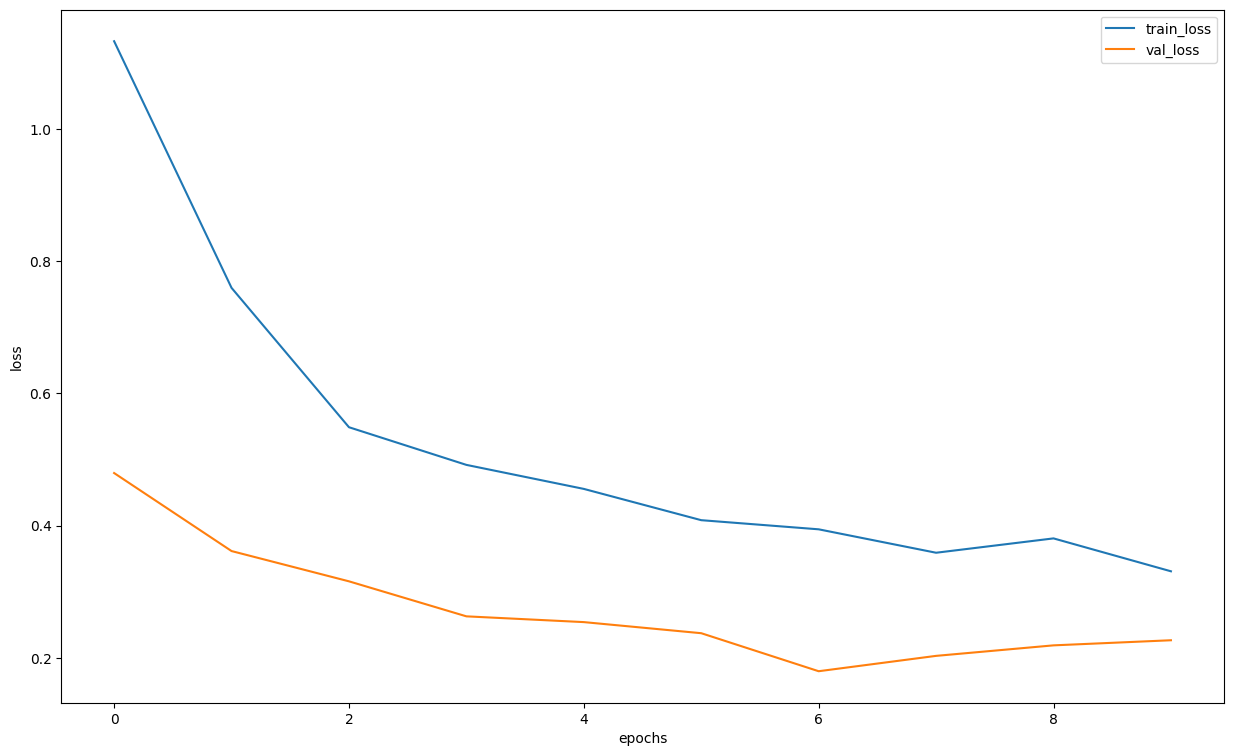

In [57]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Итого:
- Нормализация и аугментация картинок
- Обучали на базе ResNet50 с дообучением линейного и последнего сверточного слоя
val_accuracy = 

# **Дообучением на базе ResNet (обучаем линейный слой и последний слой свертки) + SGD** 

Использование scheduler для уменьшения learning rate может улучшить качество и стабильность обучения, особенно при fine-tuning’е предобученных моделей, как resnet50.

In [58]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [59]:
def train(train_files, val_files, model, epochs, batch_size, optimiser, criterion):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimiser
        criterion = criterion

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [61]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
in_features = model.fc.in_features 
model.fc = nn.Linear(in_features, n_classes)

for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

resnet50 = model.to(DEVICE)


optimiser = torch.optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=2, gamma=0.5)

criterion = torch.nn.CrossEntropyLoss()

history = train(train_dataset, val_dataset, model=resnet50, epochs=10, batch_size=128, optimiser=optimiser, criterion=criterion)


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.297437618405844



epoch:  10%|█         | 1/10 [03:49<34:28, 229.87s/it]
                                                   
epoch:  10%|█         | 1/10 [03:49<34:28, 229.87s/it]


Epoch 001 train_loss: 2.2974     val_loss 1.0737 train_acc 0.4196 val_acc 0.7608
loss 0.9589905503396207



epoch:  20%|██        | 2/10 [07:18<28:57, 217.19s/it]
                                                   
epoch:  20%|██        | 2/10 [07:18<28:57, 217.19s/it]


Epoch 002 train_loss: 0.9590     val_loss 0.5748 train_acc 0.7512 val_acc 0.8441
loss 0.7007067471266142



epoch:  30%|███       | 3/10 [10:45<24:48, 212.62s/it]
                                                   
epoch:  30%|███       | 3/10 [10:45<24:48, 212.62s/it]


Epoch 003 train_loss: 0.7007     val_loss 0.4731 train_acc 0.8141 val_acc 0.8760
loss 0.5757201753214549



epoch:  40%|████      | 4/10 [14:12<21:02, 210.37s/it]
                                                   
epoch:  40%|████      | 4/10 [14:12<21:02, 210.37s/it]


Epoch 004 train_loss: 0.5757     val_loss 0.3482 train_acc 0.8432 val_acc 0.9081
loss 0.535081008568912



epoch:  50%|█████     | 5/10 [17:40<17:27, 209.47s/it]
                                                   
epoch:  50%|█████     | 5/10 [17:40<17:27, 209.47s/it]


Epoch 005 train_loss: 0.5351     val_loss 0.3793 train_acc 0.8567 val_acc 0.8987
loss 0.48774707323996547



epoch:  60%|██████    | 6/10 [21:07<13:54, 208.71s/it]
                                                   
epoch:  60%|██████    | 6/10 [21:07<13:54, 208.71s/it]


Epoch 006 train_loss: 0.4877     val_loss 0.2616 train_acc 0.8664 val_acc 0.9293
loss 0.43597661224252304



epoch:  70%|███████   | 7/10 [24:33<10:23, 207.81s/it]
                                                   
epoch:  70%|███████   | 7/10 [24:33<10:23, 207.81s/it]


Epoch 007 train_loss: 0.4360     val_loss 0.2698 train_acc 0.8802 val_acc 0.9310
loss 0.4138225405559744



epoch:  80%|████████  | 8/10 [28:02<06:56, 208.18s/it]
                                                   
epoch:  80%|████████  | 8/10 [28:02<06:56, 208.18s/it]


Epoch 008 train_loss: 0.4138     val_loss 0.2332 train_acc 0.8873 val_acc 0.9402
loss 0.39581503232304965



epoch:  90%|█████████ | 9/10 [31:30<03:28, 208.22s/it]
                                                   
epoch:  90%|█████████ | 9/10 [31:30<03:28, 208.22s/it]


Epoch 009 train_loss: 0.3958     val_loss 0.2852 train_acc 0.8942 val_acc 0.9253
loss 0.3855952533599457



epoch: 100%|██████████| 10/10 [34:57<00:00, 207.70s/it]
                                                    
epoch: 100%|██████████| 10/10 [34:57<00:00, 209.72s/it]


Epoch 010 train_loss: 0.3856     val_loss 0.2456 train_acc 0.8945 val_acc 0.9333


Видим, что SGD дал точность чуть хуже, чем ранее представленная модель с Adam

In [64]:
# history = [(train_loss, train_acc, val_loss, val_acc), ...]

# Найдём эпоху с минимальной val_loss
best_epoch_by_loss = min(enumerate(history), key=lambda x: x[1][2])
best_epoch_idx = best_epoch_by_loss[0]
best_val_loss = best_epoch_by_loss[1][2]
best_val_acc = best_epoch_by_loss[1][3]

print(f"🏆 Лучшая эпоха по val_loss: {best_epoch_idx + 1}")
print(f"   val_loss = {best_val_loss:.4f}, val_acc = {best_val_acc:.4f}")


🏆 Лучшая эпоха по val_loss: 8
   val_loss = 0.2332, val_acc = 0.9402


In [65]:
best_epoch_by_acc = max(enumerate(history), key=lambda x: x[1][3])
print(f"📈 Лучшая эпоха по val_acc: {best_epoch_by_acc[0] + 1}")
print(f"   val_acc = {best_epoch_by_acc[1][3]:.4f}, val_loss = {best_epoch_by_acc[1][2]:.4f}")


📈 Лучшая эпоха по val_acc: 8
   val_acc = 0.9402, val_loss = 0.2332


In [ ]:
# сохранить модель
torch.save(model.state_dict(), "best_model.pth")

# позже загрузить её:
model.load_state_dict(torch.load("best_model.pth"))
